- leave running for 10+ hours to get ~50,000 tweets
- use keywords for scraping filter = ['trump','bush','cruz','kasich','rubio','clinton','sanders'] 
- Check sentiment analysis 
    - if sentiment analysis looks innaccurate - does it still correlate with favorable/unfavorable ranking (different from voting - how do you like them) Real Clear Politics does an average
- how many pos/neg tweets per candidate --- compare against number of tweets, so could say ok trump has most tweets, but not all positive 
- compare 'who's winning on twitter' with poll data 
- can conclude candidate more popular on twitter than in polls, alt. is that twitter is good predictor for poll data 
- what are common topics ... topic clustering - does it vary by candidate? 

# First pass at exploring Twitter scraping
- used tweepy to scrape the data & output json file 

In [80]:
from pymongo import MongoClient
import json
import tweepy
from tweepy import Stream
from tweepy.streaming import StreamListener
import time
import numpy as np
import tweetExplore_fns as fns
import importlib
import matplotlib
import matplotlib.pyplot as plt

importlib.reload(fns);
%matplotlib inline



## organizing the data

In [6]:
#  import data 
# with open('raw_tweets10min.json') as data_file:
with open('../data/raw_tweetsfilter10min_poli.json') as data_file:
# with open('raw_tweets10min_loc.json') as data_file:
# with open('raw_tweets40min_bosSC.json') as data_file:
    rawdata = json.load(data_file)

# selects only tweets that have text 
tweet_list = fns.extract_tweets(rawdata)
        
#  extract indices for tweets that also have a fields of interest
coord_index_list = fns.extract_indices(tweet_list,"coordinates")

# extract tweets that also have a gps coordinate 
coord_tweet_list = fns.extract_tweets_fieldOfInterest(tweet_list,"coordinates")

print('N coordinates:',len(coord_index_list), 'N Tweets', len(tweet_list))

N coordinates: 10 N Tweets 10664


## Trying out the textblob sentiment analysis

In [19]:
from textblob import TextBlob

candidates = ['trump','bush','cruz','kasich','rubio','clinton','sanders'] #track list

# for each candidate
index_store = []
subjectivity_store = []
polarity_store = []
for iperson,val in enumerate(candidates):
    # save each candidate's list of polarity etx. in a list 
    person_sentiment_polarity, person_sentiment_subjectivity, person_tweetInd = fns.extract_sentiment(tweet_list,candidates[iperson])
    polarity_store.append(person_sentiment_polarity)
    subjectivity_store.append(person_sentiment_subjectivity)
    index_store.append(person_tweetInd)

trump   # tweets: 4264 avg polarity: 0.0671094507899
bush   # tweets: 481 avg polarity: 0.0197927269802
cruz   # tweets: 1625 avg polarity: 0.0449018535718
kasich   # tweets: 158 avg polarity: 0.060992360312
rubio   # tweets: 432 avg polarity: 0.0377934854497
clinton   # tweets: 844 avg polarity: 0.0499036865994
sanders   # tweets: 916 avg polarity: 0.0264118052175


In [20]:
# sort tweets into positive/negative for each candidate 
# for each candidate
store_pos_polarity = []
store_ind_pos_polarity = []
store_tweet_pos_polarity = []
store_neg_polarity = []
store_ind_neg_polarity = []
store_tweet_neg_polarity = []
pos_neg_ratio = []

for person,val in enumerate(candidates):
    pos_polarity = []
    ind_pos_polarity = []
    tweet_pos_polarity = []
    neg_polarity = []
    ind_neg_polarity = []
    tweet_neg_polarity = []
    current_polarity = polarity_store[person]
    current_indices = index_store[person]
    for i,val in enumerate(current_polarity):
        if val > 0: 
            pos_polarity.append(current_polarity[i])
            ind_pos_polarity.append(current_indices[i])
            tweet_pos_polarity.append(tweet_list[current_indices[i]]['text'])
        else:
            neg_polarity.append(current_polarity[i])
            ind_neg_polarity.append(current_indices[i])
            tweet_neg_polarity.append(tweet_list[current_indices[i]]['text'])
            
    store_pos_polarity.append(pos_polarity)
    store_ind_pos_polarity.append(ind_pos_polarity)
    store_tweet_pos_polarity.append(tweet_pos_polarity)
    store_neg_polarity.append(neg_polarity)
    store_ind_neg_polarity.append(ind_neg_polarity)
    store_tweet_neg_polarity.append(tweet_neg_polarity)
    pos_neg_ratio.append(len(ind_pos_polarity)/len(ind_neg_polarity))
    print(candidates[person],'# positive tweets',len(ind_pos_polarity),'# negative tweets:',len(ind_neg_polarity),
          'avg + sentiment:',np.average(pos_polarity),'avg - sentiment:',np.average(neg_polarity))

trump # positive tweets 1464 # negative tweets: 2800 avg + sentiment: 0.376840439161 avg - sentiment: -0.0948356088439
bush # positive tweets 122 # negative tweets: 359 avg + sentiment: 0.334124012372 avg - sentiment: -0.0870273755763
cruz # positive tweets 430 # negative tweets: 1195 avg + sentiment: 0.384364121417 avg - sentiment: -0.0772477490838
kasich # positive tweets 55 # negative tweets: 103 avg + sentiment: 0.300466942149 avg - sentiment: -0.066882416397
rubio # positive tweets 114 # negative tweets: 318 avg + sentiment: 0.321508098687 avg - sentiment: -0.063915526843
clinton # positive tweets 264 # negative tweets: 580 avg + sentiment: 0.319041522162 avg - sentiment: -0.0726004316565
sanders # positive tweets 266 # negative tweets: 650 avg + sentiment: 0.251482722013 avg - sentiment: -0.0656941391941


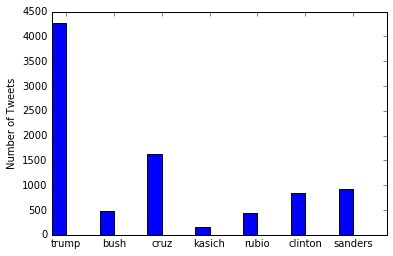

In [21]:
candidate_tweets = []
pos_tweets = []
neg_tweets = []
avg_pos = []
avg_neg = []
for i,val in enumerate(index_store):
    candidate_tweets.append(len(index_store[i]))
    pos_tweets.append(len(store_ind_pos_polarity[i]))
    neg_tweets.append(len(store_ind_neg_polarity[i]))
    avg_pos.append(np.average(store_pos_polarity[i]))
    avg_neg.append(np.average(store_neg_polarity[i]))
    
fig = plt.gcf()
matplotlib.rc('xtick',labelsize = 10)
matplotlib.rc('ytick',labelsize = 10)
# matplotlib.rc('ylabel',labelsize = 2b0)
plt.ylabel('Number of Tweets')
ind = np.arange(len(candidates))
width = .3
rect1 = plt.bar(ind, candidate_tweets, width, color = 'blue')
plt.xticks(ind+.3, candidates);

In [43]:
ymax = np.max([neg_tweets,pos_tweets])
ymax

2800

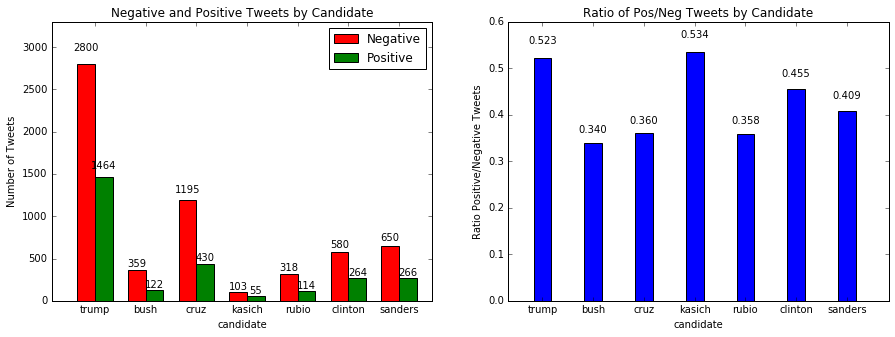

[<matplotlib.axes._subplots.AxesSubplot object at 0x127cc95f8>, <matplotlib.axes._subplots.AxesSubplot object at 0x12c071d30>]


In [56]:
ind = np.arange(len(candidates))  # the x locations for the groups
width = 0.35       # the width of the bars
ax = [0,1]
ind = np.arange(len(candidates))+1
from matplotlib import gridspec
fig = plt.figure(figsize=(15, 5)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1]) 
ax[0] = plt.subplot(gs[0])
rects1 = ax[0].bar(ind, neg_tweets, width, color='r') #, yerr=menStd
rects2 = ax[0].bar(ind + width, pos_tweets, width, color='g') #, yerr=womenStd

ymax = np.max([neg_tweets,pos_tweets]) + 500

# add some text for labels, title and axes ticks
ax[0].set_title('Negative and Positive Tweets by Candidate')
ax[0].legend((rects1[0], rects2[0]), ('Negative', 'Positive'))
ax[0].set_xlabel("candidate")
ax[0].set_ylabel("Number of Tweets")
ax[0].set_xticklabels(candidates)
ax[0].set_xlim([.5,8])
ax[0].set_ylim([0,ymax])
ax[0].set_xticks(ind+width)
# label bars with y value, integer
fns.autolabelInt(rects1,0,ax)
fns.autolabelInt(rects2,0,ax)

ax[1] = plt.subplot(gs[1])
ax[1].set_title('Ratio of Pos/Neg Tweets by Candidate')

rect1 = ax[1].bar(ind, pos_neg_ratio, width, color = 'blue')
ax[1].set_xlabel("candidate")
ax[1].set_ylabel("Ratio Positive/Negative Tweets")
ax[1].set_xticks(ind+width/2)
ax[1].set_xlim([.5,8])
ax[1].set_xticklabels(candidates) #rotation = 30

# label y value of bars, decimal 
fns.autolabelDec(rect1,1,ax)
plt.show()
print(ax)

interesting, Kasich has the least tweets, but the best pos/negative ratio 

//anaconda/lib/python3.5/site-packages/PIL/ImageDraw.py:104: UserWarning: setfont() is deprecated. Please set the attribute directly instead.
  "Please set the attribute directly instead.")


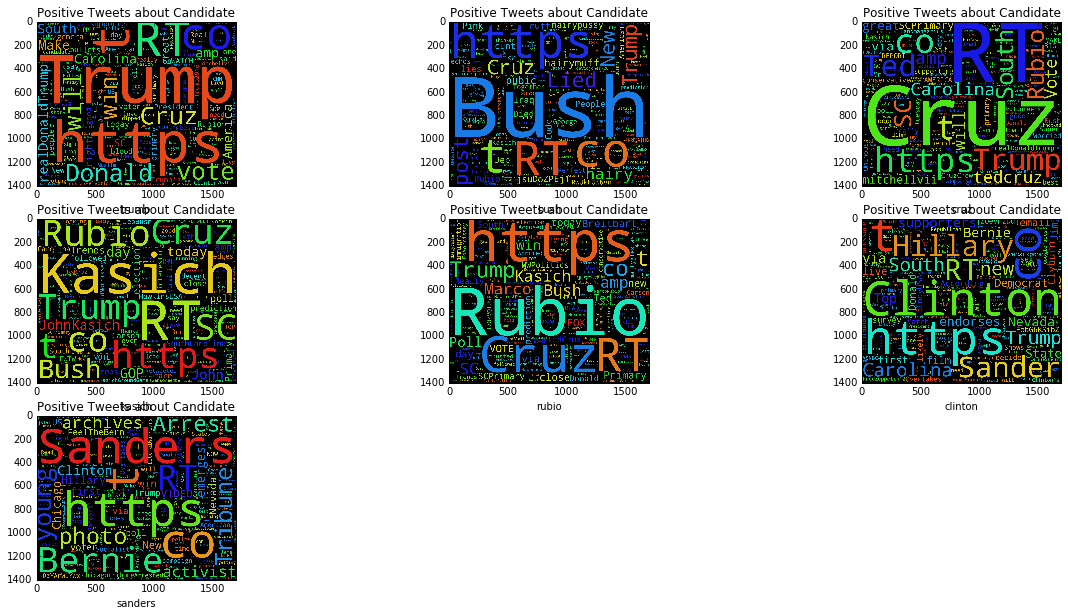

In [88]:
ind = np.arange(len(candidates))  # the x locations for the groups
width = 0.35       # the width of the bars
from matplotlib import gridspec
fig = plt.figure(figsize = (40,10)) #figsize=(90, 90)
ax = []
gs = gridspec.GridSpec(3, 3, width_ratios=[1, 1, 1, 1, 1, 1, 1])
for i, val in enumerate(candidates):
    ax.append(plt.subplot(gs[i]))
    tempwordcloud = fns.makeWordcloud(store_tweet_pos_polarity[i])
    ax[i].imshow(tempwordcloud)
    # add some text for labels, title and axes ticks
    ax[i].set_title('Positive Tweets about Candidate')
    ax[i].set_xlabel(candidates[i])

plt.show()

correlation between Real Clear Politics Favorable/Unfavorable ratings and Positive/Negative: 1.61023530044


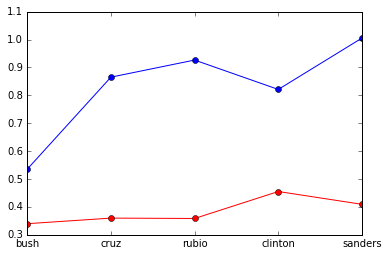

In [126]:
rcp_candidates = ['bush','cruz','rubio','clinton','sanders'] #'trump','kasich',#track list
rcp_inds = np.array([1,2,4,5,6])
rcp_pos_neg_ratio = []
xind = np.arange(len(rcp_candidates))
for i, vals in enumerate(rcp_inds):
    rcp_pos_neg_ratio.append(pos_neg_ratio[rcp_inds[i]])
    
rcp_favorable = np.array([29,34.6,35.2,42.2,38.4])
rcp_unfavorable = np.array([54.2,40,38,51.4,38.2])
type(rcp_unfavorable)
fav_unfav_ratio = rcp_favorable/rcp_unfavorable
rcp_pos_corr = np.correlate(fav_unfav_ratio,rcp_pos_neg_ratio)
plt.plot(xind,fav_unfav_ratio,c='b',marker = 'o')
plt.plot(xind,rcp_pos_neg_ratio,c='r',marker='o')
plt.xticks(xind, rcp_candidates)

plt.show;
print('correlation between Real Clear Politics Favorable/Unfavorable ratings and Positive/Negative:',
     rcp_pos_corr[0])

## Plot geographical coordinates of tweets

In [ ]:
# This just lets the output of the following code samples
#  display inline on this page, at an appropriate size.
from pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = (10,20)

In [ ]:
import matplotlib
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
# setup Lambert Conformal basemap.
m = Basemap(projection='lcc',width=12000000,height=9000000,
            resolution='l',lat_1=45.,lat_2=55,lat_0=50,lon_0=-107.)
#draw boundary, fill ocean color
m.drawmapboundary(fill_color='#CCFFFF')
# fill continents, set lake color
m.fillcontinents(color='#66CC99',lake_color='#CCFFFF') # '#6699CC'
# draw parallels and meridians. label only on edges of map
parallels = np.arange(0.,81,10.)
m.drawparallels(parallels,labels=[False,True,True,False])
meridians = np.arange(10.,351.,20.)
m.drawmeridians(meridians,labels=[True,False,False,True])
# drawstates, if no linewidth will be empty
m.drawstates(linewidth = .5)
m.drawcoastlines()
m.drawcountries()
# m.drawcounties(linewidth = 0.05, linestyle = 'solid', color = 'k', antialiased = 1)

i = 0
while i < len(coords):
    # get current coordinates 
    lon, lat = coords[i]
    # convert to map projection coords.
    # Note that lon,lat can be scalars, lists or numpy arrays.
    xpt,ypt = m(lon,lat)
    # convert back to lat/lon
    lonpt, latpt = m(xpt,ypt,inverse=True)
    m.plot(xpt,ypt,'ro')  # plot a blue dot there
    label = 'Hello'
    plt.Text(xpt+1000, ypt+5000, label)
    # put some text next to the dot, offset a little bit
    # (the offset is in map projection coordinates)
#     plt.text(xpt+100000,ypt+100000,'Boulder (%5.1fW,%3.1fN)' % (lonpt,latpt))
#     plt.text(xpt+100000,ypt+100000,'(%5.1fW,%3.1fN)' % (i,lonpt,latpt))
    i = i + 1
plt.show()

In [ ]:
rcParams['figure.figsize'] = (20,20)

 
# make sure the value of resolution is a lowercase L,
#  for 'low', not a numeral 1
# my_map = Basemap(projection='ortho', lat_0=50, lon_0=-100,
#               resolution='l', area_thresh=1000.0)
# my_map = Basemap(projection='robin', lat_0=50, lon_0=-100,
#               resolution='l', area_thresh=1000.0)
my_map = Basemap(projection='merc', lat_0=42.36, lon_0=-71.06,
              resolution='h', area_thresh=.01, 
              llcrnrlon=-71.3, llcrnrlat=42.1,
              urcrnrlon=-70.9, urcrnrlat=42.6) 
#               llcrnrlon=-71.098709, llcrnrlat=42.328093,
#               urcrnrlon=-71.012192, urcrnrlat=42.389994) 
my_map.drawcoastlines()
my_map.drawcountries()
my_map.fillcontinents(color='#66CC99')
my_map.drawstates(linewidth = .5)
my_map.drawmapboundary()
my_map.drawmeridians(np.arange(0, 360, 30))
my_map.drawparallels(np.arange(-90, 90, 30))
# my_map.drawcounties(linewidth = 0.5)

# lon = -135.3318
# lat = 57.0799
# x,y = my_map(lon, lat)
# my_map.plot(x, y, 'bo', markersize=12)
i = 0
while i < len(coords):
    # get current coordinates 
    lon, lat = coords[i]
    # convert to map projection coords.
    # Note that lon,lat can be scalars, lists or numpy arrays.
    xpt,ypt = my_map(lon,lat)
    # convert back to lat/lon
    lonpt, latpt = my_map(xpt,ypt,inverse=True)
    my_map.plot(xpt,ypt,'ro')  # plot a blue dot there
    label = 'Hello'
    plt.Text(xpt+1000, ypt+5000, label)
    # put some text next to the dot, offset a little bit
    # (the offset is in map projection coordinates)
#     plt.text(xpt+100000,ypt+100000,'Boulder (%5.1fW,%3.1fN)' % (lonpt,latpt))
#     plt.text(xpt+100000,ypt+100000,'(%5.1fW,%3.1fN)' % (i,lonpt,latpt))
    i = i + 1
plt.show()